In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

raw = pd.read_csv('../../../../../datasets/paris_listings.csv')
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability','host_response_rate']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url':'url',
    'property_type':'숙소_특징',
    'number_of_reviews_ltm':'12개월_리뷰수',
    'has_availability':'예약가능여부',
    'host_response_rate':'응답률'
})


# 슈퍼호스트, 리뷰수 결측치 제거
print(f"처음 df : {len(df)}")
df = df[~df['슈퍼호스트'].isnull()]
print(f"슈퍼호스트 제거 : {len(df)}")
df = df[df['리뷰수']>9]
print(f"리뷰수 제거 : {len(df)}")

# 숙소가격 null값 제거
df= df[~df['숙소_가격'].isnull()]

#가격 앞 통화기호 제거
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 유형 제거 
df = df[(df['숙소_유형']=='Entire home/apt') | (df['숙소_유형']=='Private room')]
print(f"숙소_유형 제거 : {len(df)}")

# 12개월 리뷰수 0 개 제거
df = df[df['12개월_리뷰수']!=0]
print(f"12개월_리뷰수 0개 제거 : {len(df)}")

# 욕실수, 침실수, 침대수 null값 제거
df = df.dropna(subset=['욕실수', '침실수', '침대수'])
print(f"욕실수, 침실수, 침대수 제거 후 : {len(df)}")

# 리뷰  null값 제거
df = df.dropna(subset=['숙소_정확성_리뷰점수','숙소_청결도_리뷰점수','숙소_체크인_리뷰점수','숙소_소통_리뷰점수','숙소_위치_리뷰점수','숙소_가격_리뷰점수'])
print(f"리뷰 결측치 제거 후 : {len(df)}")


# 예약 가능여부 f 버리기
df = df.dropna(subset='예약가능여부')
print(f"예약가능여부 : {len(df)}")


##########################################################
# 응답률 버리기
df = df.dropna(subset='응답률')
print(f"응답률 : {len(df)}")

#응답률 앞 통화기호 제거
df['응답률'] = df['응답률'].replace('[\%,]', '', regex=True).astype(float)

처음 df : 84397
슈퍼호스트 제거 : 84306
리뷰수 제거 : 31465
숙소_유형 제거 : 23879
12개월_리뷰수 0개 제거 : 22037
욕실수, 침실수, 침대수 제거 후 : 21994
리뷰 결측치 제거 후 : 21994
예약가능여부 : 21989
응답률 : 18977


In [2]:
df.isnull().sum()

숙소_id          0
호스트_id         0
슈퍼호스트          0
숙소_수           0
숙소_지역          0
숙소_유형          0
수용_인원수         0
욕실수            0
침실수            0
침대수            0
편의시설           0
숙소_가격          0
최소_숙박일         0
최대_숙박일         0
리뷰수            0
30일_리뷰수        0
리뷰점수           0
숙소_정확성_리뷰점수    0
숙소_청결도_리뷰점수    0
숙소_체크인_리뷰점수    0
숙소_소통_리뷰점수     0
숙소_위치_리뷰점수     0
숙소_가격_리뷰점수     0
평균_리뷰수         0
url            0
숙소_특징          0
12개월_리뷰수       0
예약가능여부         0
응답률            0
dtype: int64

In [3]:
df.describe()

,숙소_id,호스트_id,숙소_수,수용_인원수,욕실수,침실수,침대수,숙소_가격,최소_숙박일,최대_숙박일,...,리뷰점수,숙소_정확성_리뷰점수,숙소_청결도_리뷰점수,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,12개월_리뷰수,응답률
count,1.897700e+04,1.897700e+04,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,...,18977.00000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000
mean,3.506075e+17,1.437455e+08,24.233651,3.330189,1.186199,1.246720,1.817885,194.970227,4.211572,476.398799,...,4.75120,4.794807,4.694874,4.832714,4.852803,4.835876,4.647154,1.864586,19.628867,96.446435
std,4.073920e+17,1.706684e+08,87.339476,1.795791,0.572859,0.980223,1.328136,478.014792,14.401018,463.342349,...,0.21925,0.189963,0.266928,0.179570,0.176043,0.176988,0.230586,1.607980,18.592845,12.927324
min,5.396000e+03,2.626000e+03,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,...,2.86000,3.000000,2.380000,3.080000,3.360000,2.670000,2.770000,0.070000,1.000000,0.000000
25%,2.259435e+07,1.423730e+07,1.000000,2.000000,1.000000,1.000000,1.000000,100.000000,2.000000,30.000000,...,4.64000,4.710000,4.570000,4.770000,4.800000,4.780000,4.530000,0.790000,9.000000,100.000000
50%,5.074590e+07,5.156729e+07,2.000000,3.000000,1.000000,1.000000,1.000000,142.000000,2.000000,365.000000,...,4.81000,4.850000,4.760000,4.890000,4.910000,4.890000,4.700000,1.430000,15.000000,100.000000
75%,7.728937e+17,2.444065e+08,6.000000,4.000000,1.000000,2.000000,2.000000,220.000000,3.000000,1125.000000,...,4.91000,4.930000,4.890000,4.950000,4.970000,4.950000,4.810000,2.460000,24.000000,100.000000
max,1.089036e+18,5.606732e+08,909.000000,16.000000,48.000000,50.000000,77.000000,53239.000000,365.000000,1126.000000,...,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,37.090000,825.000000,100.000000


# 슈퍼호스트 t f 차이
-슈퍼호스트인데 4.8 이하값 너무 많음

           리뷰점수  숙소_정확성_리뷰점수  숙소_청결도_리뷰점수  숙소_체크인_리뷰점수  숙소_소통_리뷰점수  \
슈퍼호스트                                                                
f      4.656306     4.722916     4.596189     4.777971    4.790172   
t      4.871972     4.886303     4.820469     4.902386    4.932513   

       숙소_위치_리뷰점수  숙소_가격_리뷰점수  
슈퍼호스트                          
f        4.805157    4.557584  
t        4.874972    4.761149  


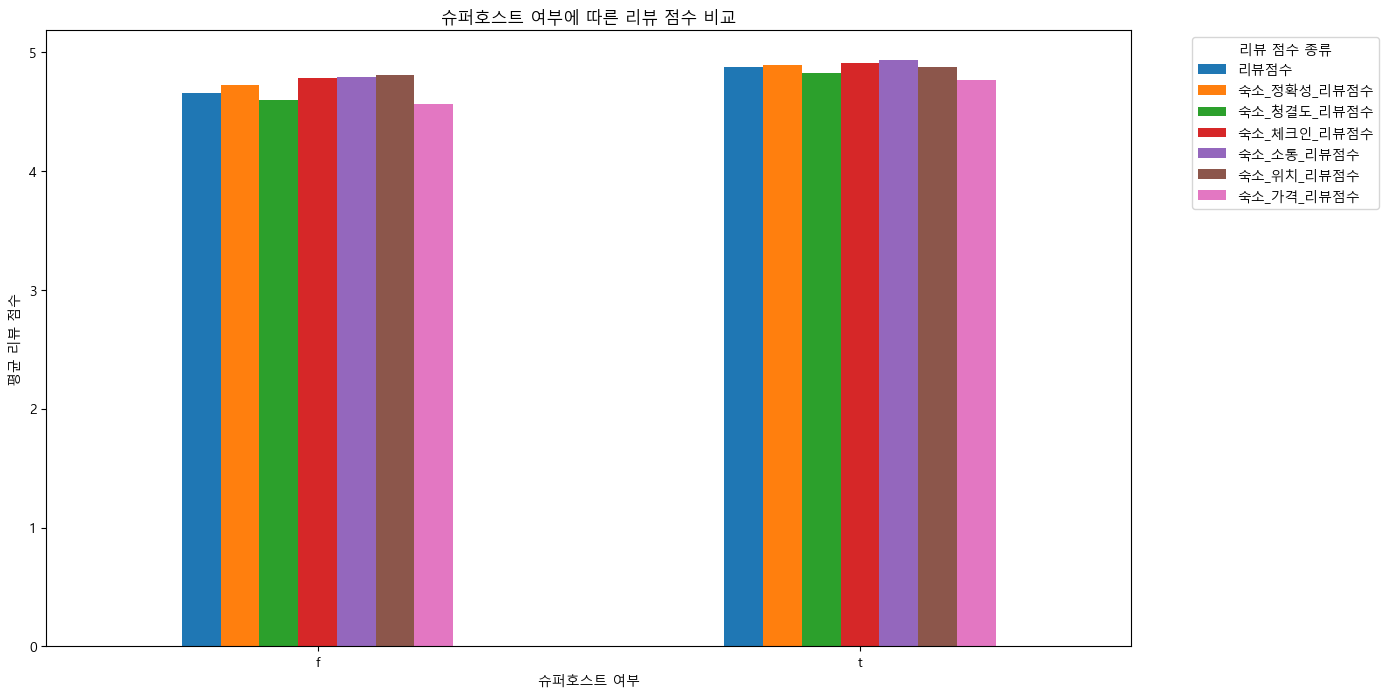

In [4]:
# 슈퍼호스트별로 각 리뷰 점수의 평균을 계산
review_scores_by_type = df.groupby('슈퍼호스트')[[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수']].mean()

# 결과 출력
print(review_scores_by_type)

# 시각화
review_scores_by_type.plot(kind='bar', figsize=(14, 8))
plt.title('슈퍼호스트 여부에 따른 리뷰 점수 비교')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('평균 리뷰 점수')
plt.xticks(rotation=0)
plt.legend(title='리뷰 점수 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


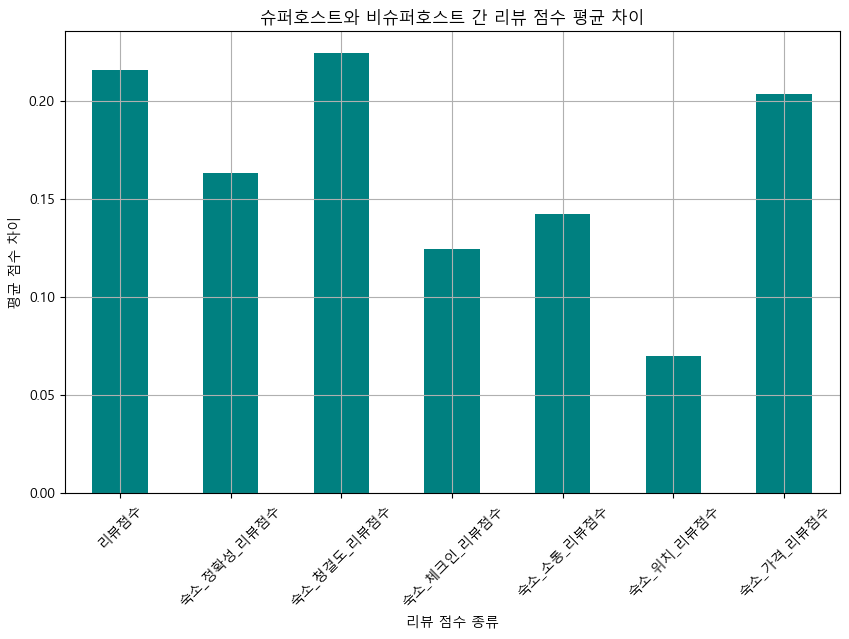

In [5]:
# 슈퍼호스트인 경우와 아닌 경우의 차이 계산
score_diff = review_scores_by_type.diff().iloc[1]

# 차이를 막대 그래프로 표시
score_diff.plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('슈퍼호스트와 비슈퍼호스트 간 리뷰 점수 평균 차이')
plt.xlabel('리뷰 점수 종류')
plt.ylabel('평균 점수 차이')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


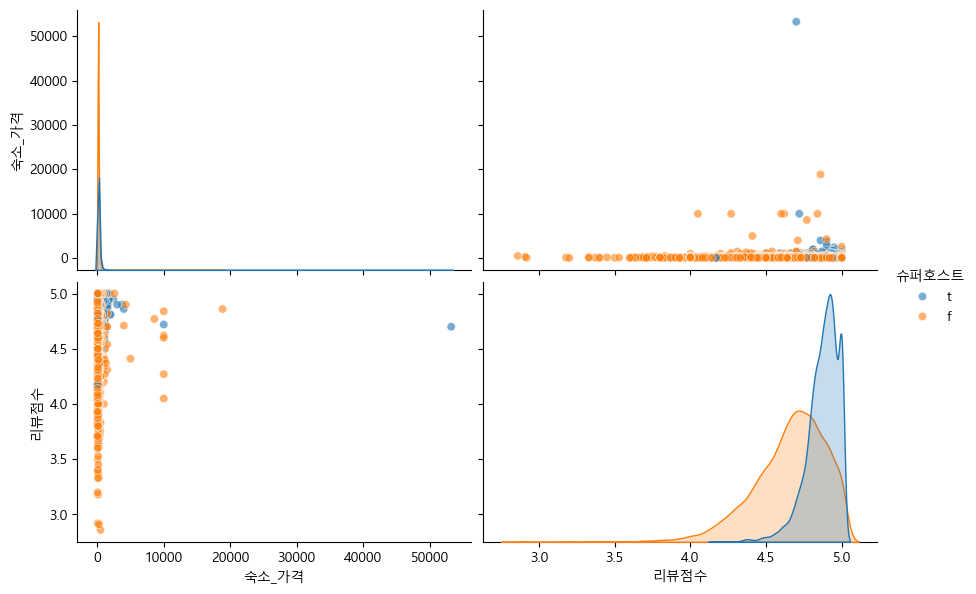

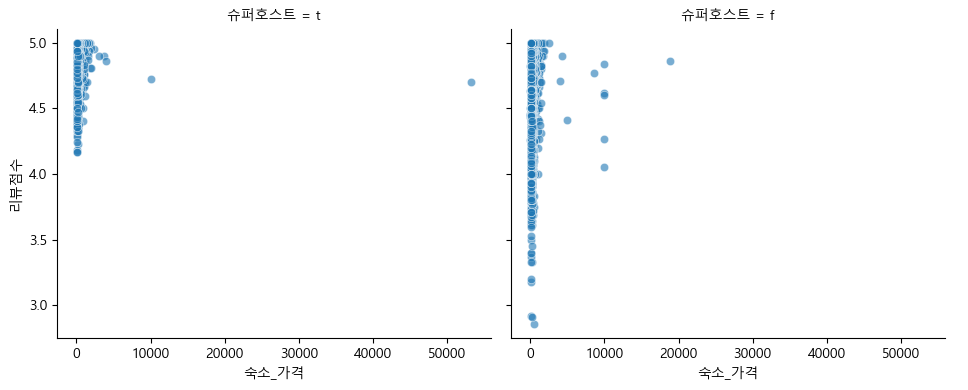

In [6]:
# Seaborn의 Pairplot을 사용하여 슈퍼호스트 여부에 따른 가격과 리뷰 점수의 관계를 그래프로 나타냄
sns.pairplot(df, vars=['숙소_가격', '리뷰점수'], hue='슈퍼호스트', height=3, aspect=1.5, plot_kws={'alpha':0.6})
plt.show()

# FacetGrid를 사용하여 좀 더 구체적인 조건부 플롯을 만들 수 있음
g = sns.FacetGrid(df, col='슈퍼호스트', height=4, aspect=1.2)
g.map(sns.scatterplot, '숙소_가격', '리뷰점수', alpha=0.6)
g.add_legend()
plt.show()

점수로그변환

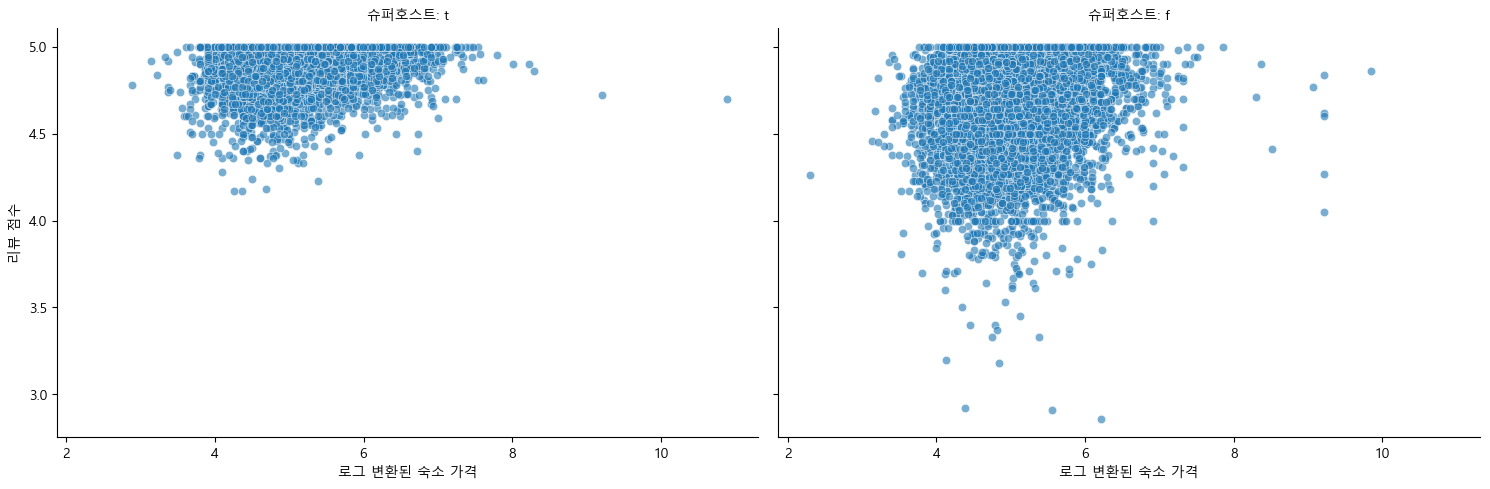

In [7]:
# 로그 변환 적용 전에 0 이상인 데이터만 필터링
df_filtered = df[df['숙소_가격'] > 0]

# 로그 변환 적용
df_filtered['로그_숙소_가격'] = np.log(df_filtered['숙소_가격'])

# 조건부 플롯 생성
g = sns.FacetGrid(df_filtered, col='슈퍼호스트', height=5, aspect=1.5)
g.map(sns.scatterplot, '로그_숙소_가격', '리뷰점수', alpha=0.6)

# 그래프 제목 및 레이블 설정
g.set_titles("슈퍼호스트: {col_name}")
g.set_axis_labels("로그 변환된 숙소 가격", "리뷰 점수")

# 플롯 표시
plt.show()


원래 데이터의 크기: 18977
이상치 제거 후 데이터의 크기: 18488


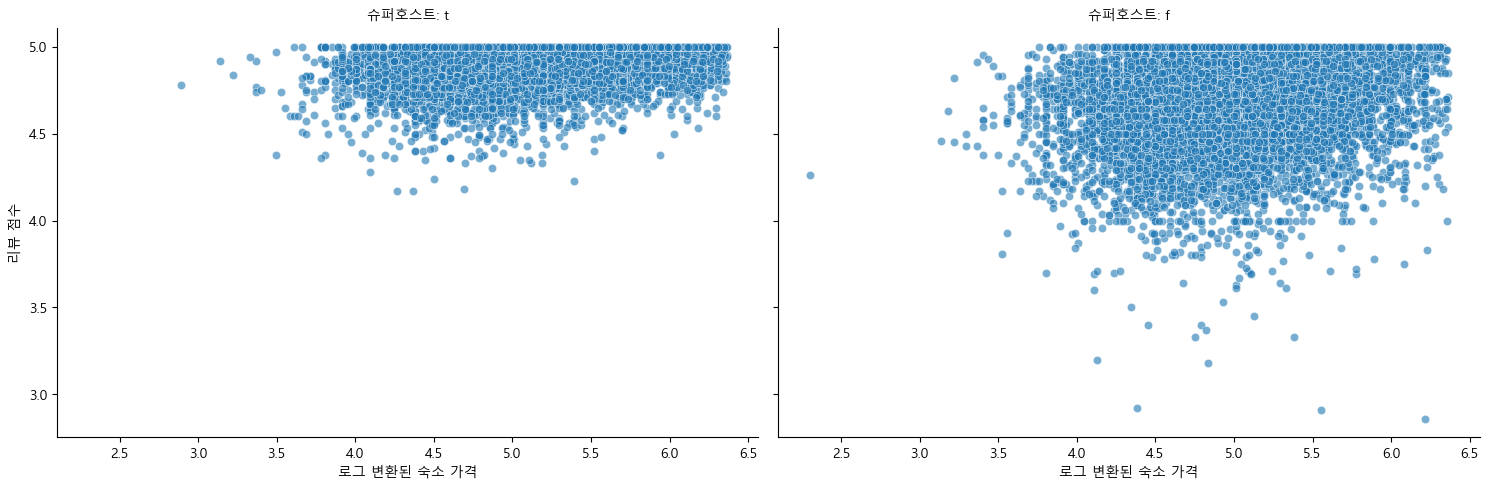

In [8]:
# 사분위수를 계산합니다.
Q1 = df['숙소_가격'].quantile(0.25)
Q3 = df['숙소_가격'].quantile(0.75)
IQR = Q3 - Q1

# 이상치가 아닌 범위를 조정하여 정의합니다.
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

print(f"원래 데이터의 크기: {len(df)}")
# 이상치를 제거합니다.
df = df[(df['숙소_가격'] >= lower_bound) & (df['숙소_가격'] <= upper_bound)]

# 로그 변환을 적용합니다.
df['로그_숙소_가격'] = np.log(df['숙소_가격'])

# 결과 확인
print(f"이상치 제거 후 데이터의 크기: {len(df)}")

# 조건부 플롯을 다시 그립니다.
g = sns.FacetGrid(df, col='슈퍼호스트', height=5, aspect=1.5)
g.map(sns.scatterplot, '로그_숙소_가격', '리뷰점수', alpha=0.6)
g.set_titles("슈퍼호스트: {col_name}")
g.set_axis_labels("로그 변환된 숙소 가격", "리뷰 점수")
plt.show()


 - 이상헤서 로그변환

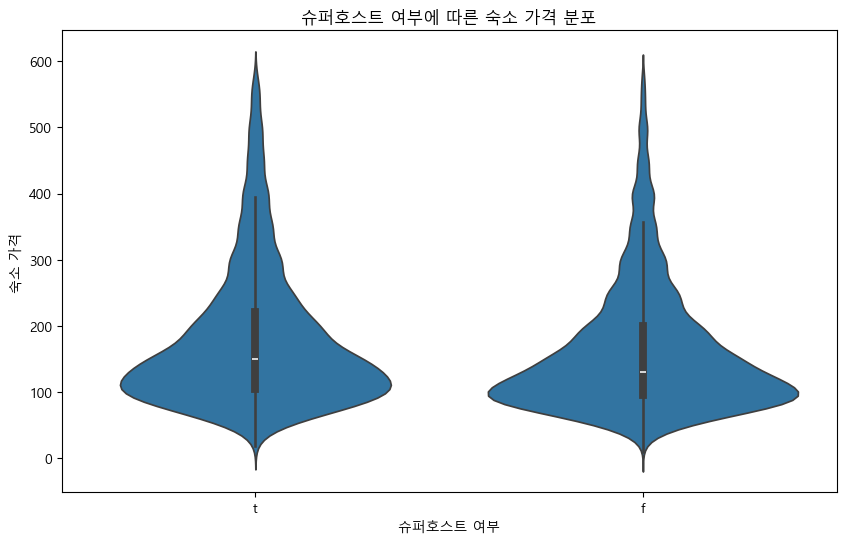

In [9]:
# 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x='슈퍼호스트', y='숙소_가격', data=df)
plt.title('슈퍼호스트 여부에 따른 숙소 가격 분포')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('숙소 가격')
plt.show()


- 슈퍼호스트기 가격에 영향을 준다?

In [10]:
from scipy.stats import mannwhitneyu

# 슈퍼호스트와 비슈퍼호스트의 가격 데이터 추출
superhost_prices = df[df['슈퍼호스트'] == 't']['숙소_가격']
nonsuperhost_prices = df[df['슈퍼호스트'] == 'f']['숙소_가격']

# Mann-Whitney U 테스트 수행
u_stat, p_value = mannwhitneyu(superhost_prices, nonsuperhost_prices, alternative='two-sided')

print("Mann-Whitney U 통계량:", u_stat)
print("P-값:", p_value)


Mann-Whitney U 통계량: 46732803.5
P-값: 6.4432252456416e-39


In [11]:
# 슈퍼호스트 숙소의 가격 중앙값
superhost_median = df[df['슈퍼호스트'] == 't']['숙소_가격'].median()

# 비슈퍼호스트 숙소의 가격 중앙값
nonsuperhost_median = df[df['슈퍼호스트'] == 'f']['숙소_가격'].median()

print("슈퍼호스트 숙소 가격 중앙값:", superhost_median)
print("비슈퍼호스트 숙소 가격 중앙값:", nonsuperhost_median)


슈퍼호스트 숙소 가격 중앙값: 150.0
비슈퍼호스트 숙소 가격 중앙값: 131.0


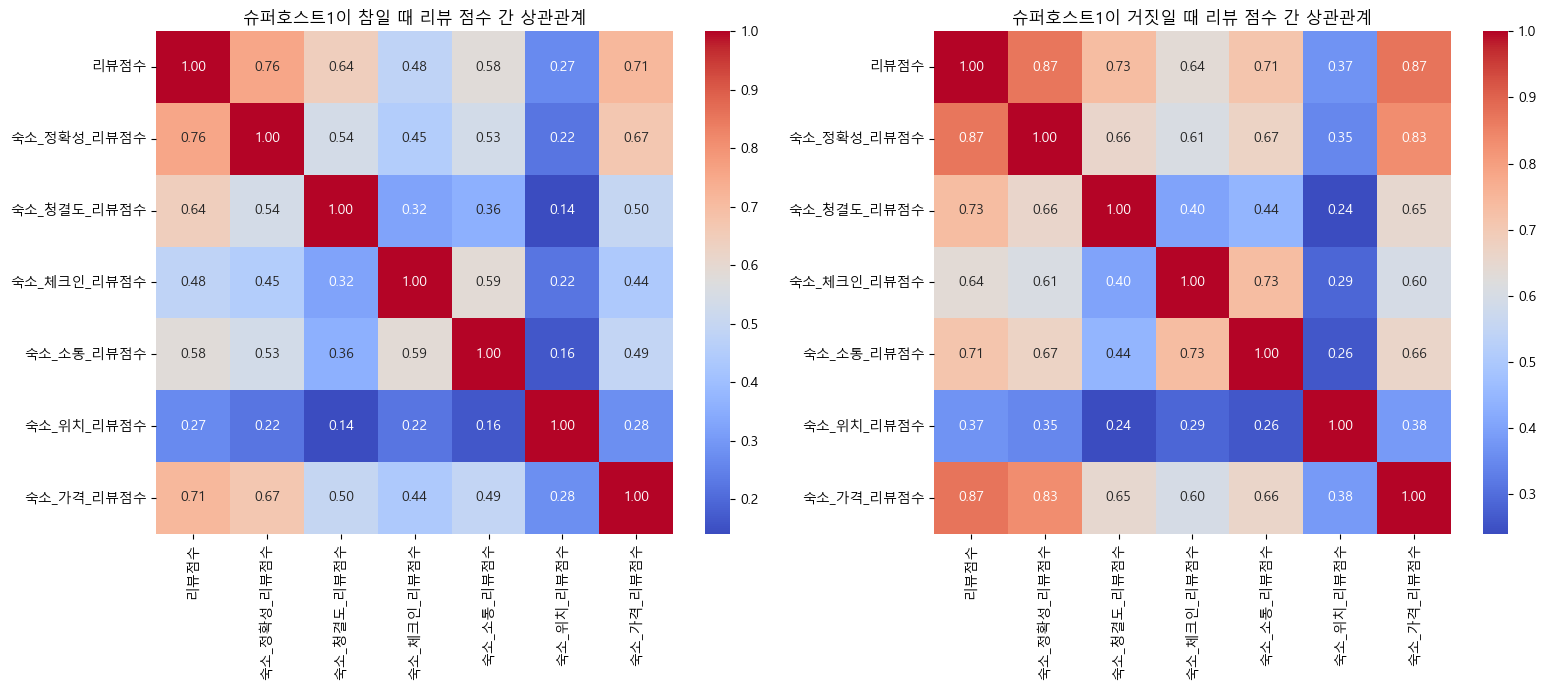

In [12]:
# 관련 리뷰 점수 컬럼 선택
review_scores_data_true = df[df['슈퍼호스트'] == 't'][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

review_scores_data_false = df[df['슈퍼호스트'] == 'f'][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

# 상관계수 계산
correlation_matrix_true = review_scores_data_true.corr()
correlation_matrix_false = review_scores_data_false.corr()

# 히트맵 생성
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)  # 첫 번째 히트맵
sns.heatmap(correlation_matrix_true, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 참일 때 리뷰 점수 간 상관관계')

plt.subplot(1, 2, 2)  # 두 번째 히트맵
sns.heatmap(correlation_matrix_false, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 거짓일 때 리뷰 점수 간 상관관계')

plt.tight_layout()
plt.show()


# 임의로 슈퍼호스트1 변수 추가 
- 리뷰점수4.8 + 응답률 90
- 상관 관계가 많이 이상함

In [13]:
df['슈퍼호스트1'] = (df['리뷰점수'] >= 4.8) & (df['응답률'] >= 90)

In [14]:
len(df[df['슈퍼호스트1']==True])

9104

            리뷰점수  숙소_정확성_리뷰점수  숙소_청결도_리뷰점수  숙소_체크인_리뷰점수  숙소_소통_리뷰점수  \
슈퍼호스트1                                                                
False   4.595808     4.679535     4.540984     4.750508    4.763859   
True    4.906446     4.910639     4.846750     4.915711    4.943498   

        숙소_위치_리뷰점수  숙소_가격_리뷰점수  
슈퍼호스트1                          
False     4.784727    4.503066  
True      4.884562    4.792375  


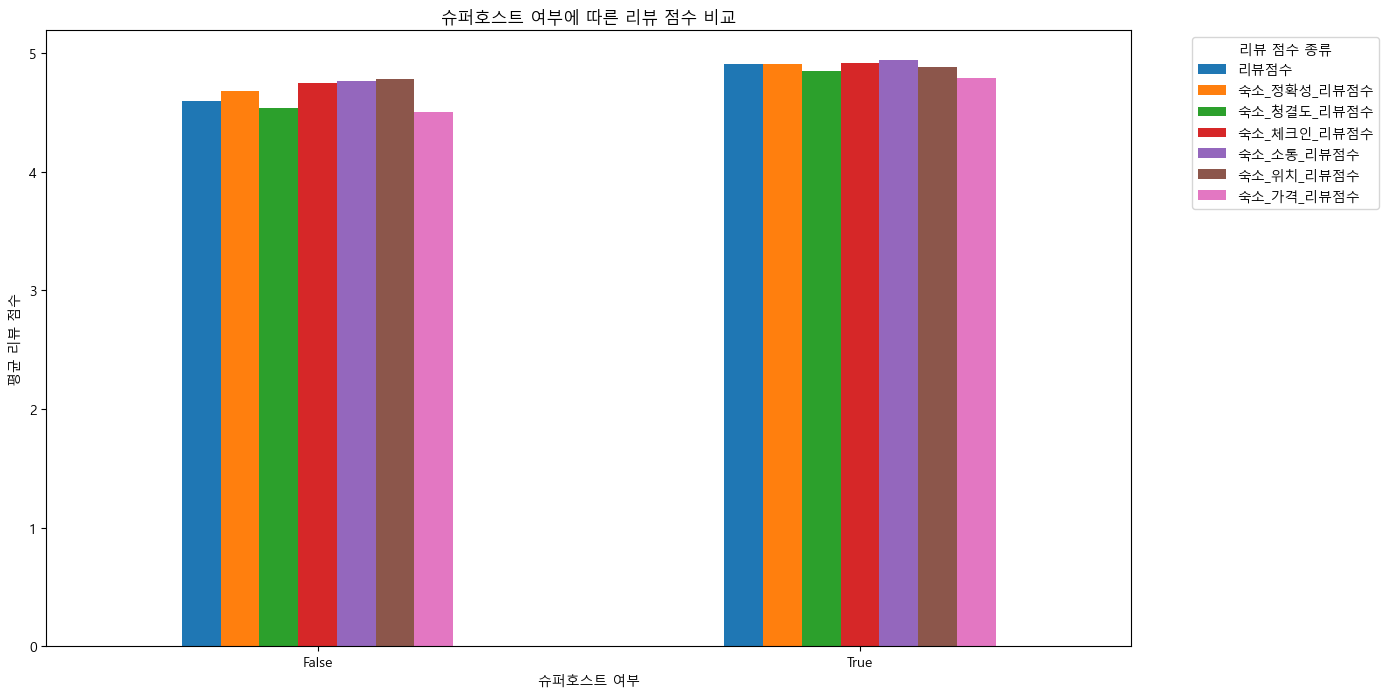

In [15]:
# 슈퍼호스트별로 각 리뷰 점수의 평균을 계산
review_scores_by_type = df.groupby('슈퍼호스트1')[[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수']].mean()

# 결과 출력
print(review_scores_by_type)

# 시각화
review_scores_by_type.plot(kind='bar', figsize=(14, 8))
plt.title('슈퍼호스트 여부에 따른 리뷰 점수 비교')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('평균 리뷰 점수')
plt.xticks(rotation=0)
plt.legend(title='리뷰 점수 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


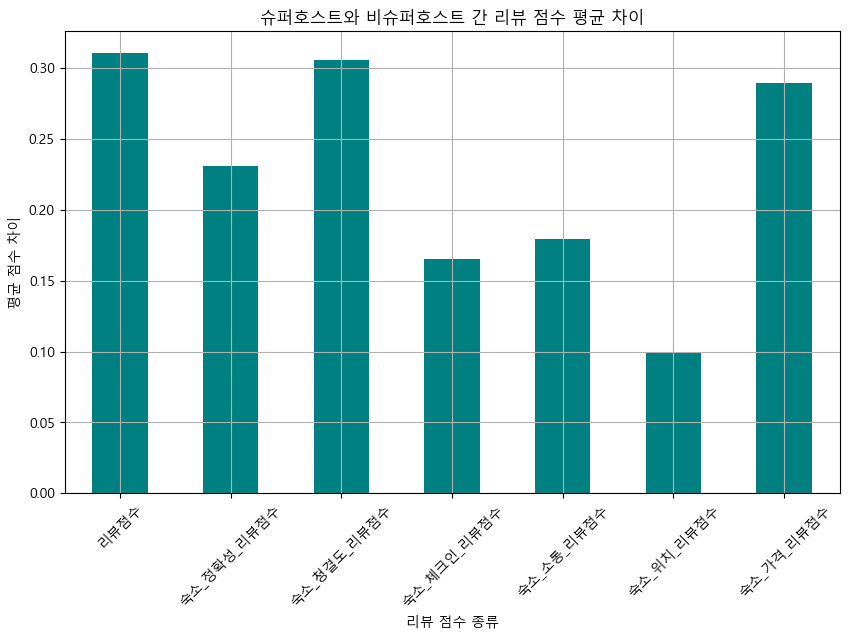

In [16]:
# 슈퍼호스트인 경우와 아닌 경우의 차이 계산
score_diff = review_scores_by_type.diff().iloc[1]

# 차이를 막대 그래프로 표시
score_diff.plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('슈퍼호스트와 비슈퍼호스트 간 리뷰 점수 평균 차이')
plt.xlabel('리뷰 점수 종류')
plt.ylabel('평균 점수 차이')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


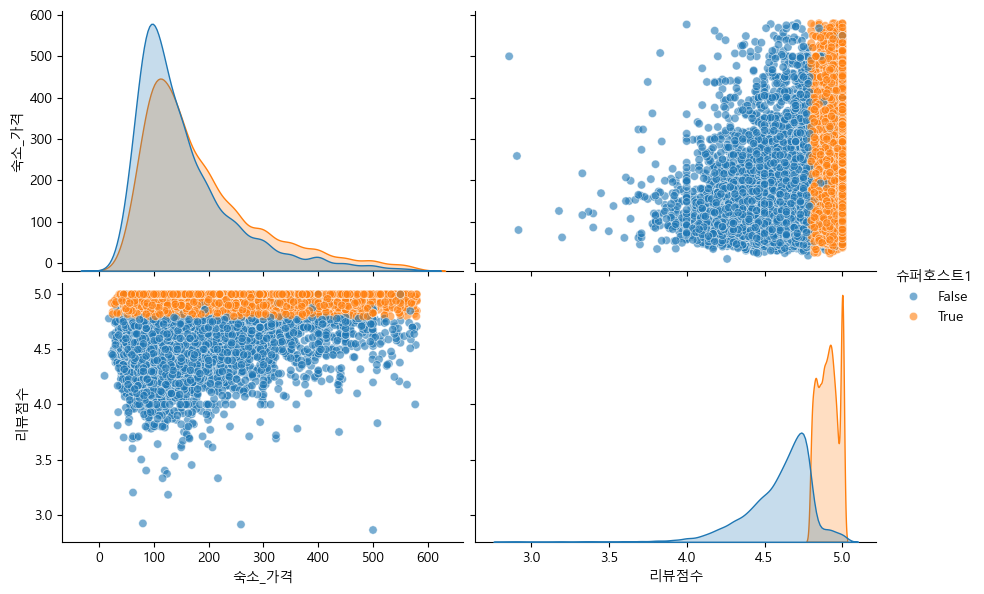

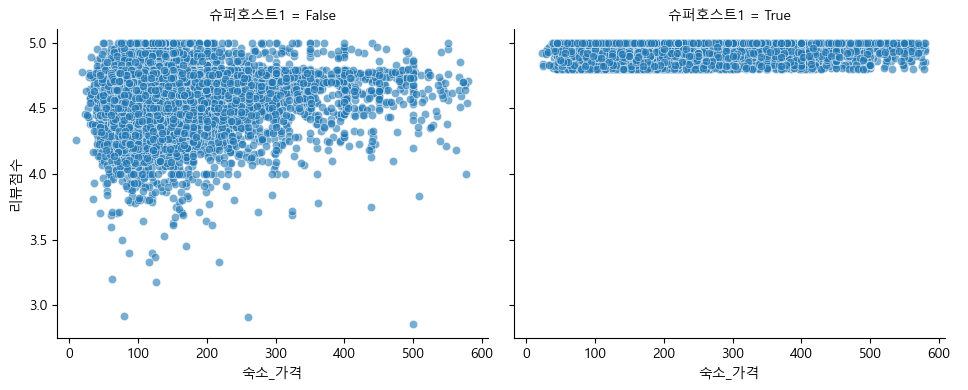

In [17]:
# Seaborn의 Pairplot을 사용하여 슈퍼호스트 여부에 따른 가격과 리뷰 점수의 관계를 그래프로 나타냄
sns.pairplot(df, vars=['숙소_가격', '리뷰점수'], hue='슈퍼호스트1', height=3, aspect=1.5, plot_kws={'alpha':0.6})
plt.show()

# FacetGrid를 사용하여 좀 더 구체적인 조건부 플롯을 만들 수 있음
g = sns.FacetGrid(df, col='슈퍼호스트1', height=4, aspect=1.2)
g.map(sns.scatterplot, '숙소_가격', '리뷰점수', alpha=0.6)
g.add_legend()
plt.show()

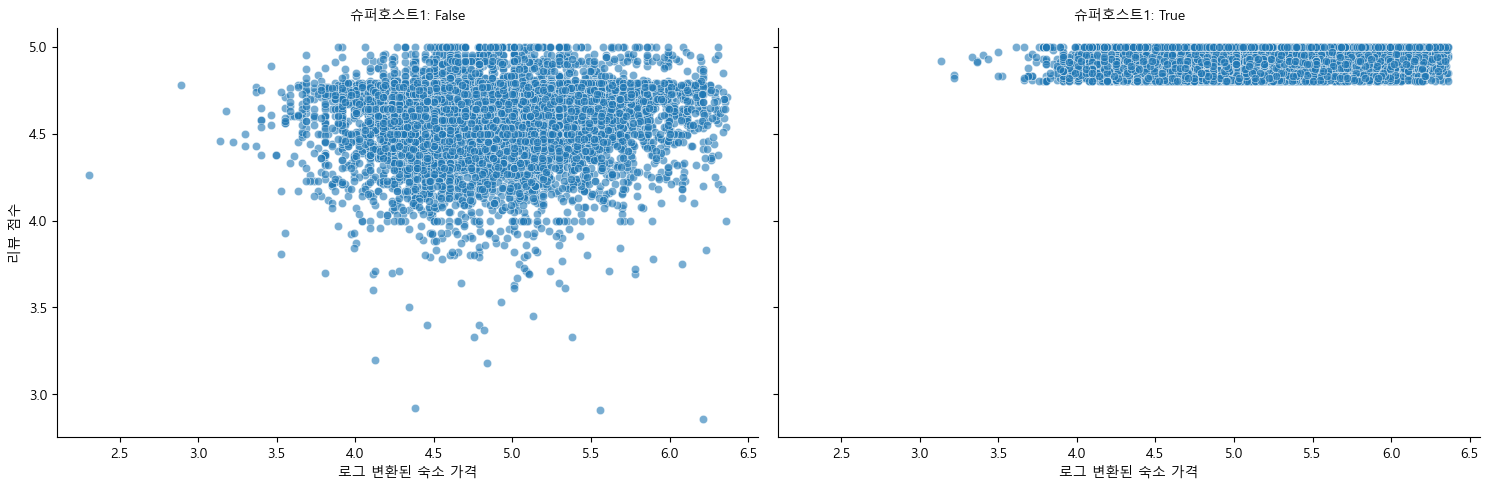

In [18]:
# 조건부 플롯 생성
g = sns.FacetGrid(df, col='슈퍼호스트1', height=5, aspect=1.5)
g.map(sns.scatterplot, '로그_숙소_가격', '리뷰점수', alpha=0.6)

# 그래프 제목 및 레이블 설정
g.set_titles("슈퍼호스트1: {col_name}")
g.set_axis_labels("로그 변환된 숙소 가격", "리뷰 점수")

# 플롯 표시
plt.show()


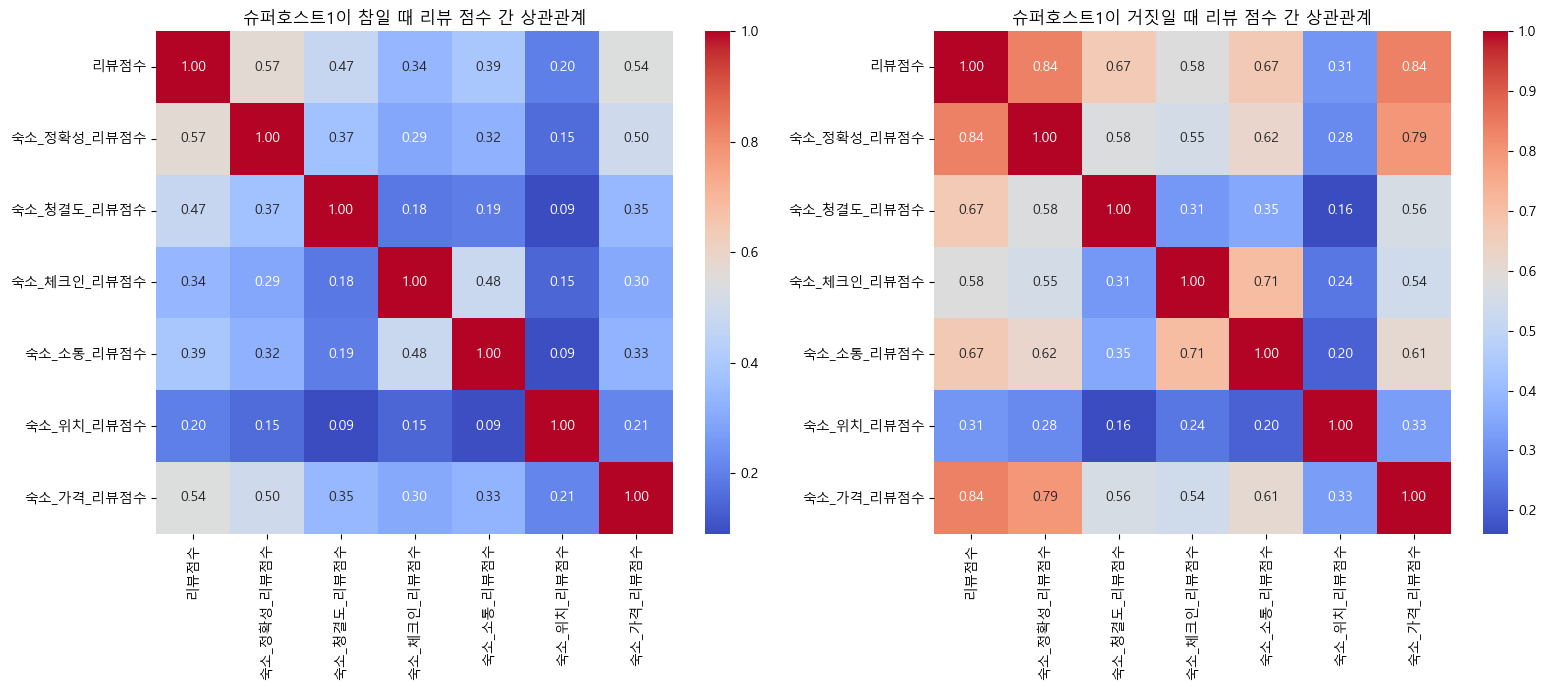

In [19]:
# 관련 리뷰 점수 컬럼 선택
review_scores_data_true = df[df['슈퍼호스트1'] == True][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

review_scores_data_false = df[df['슈퍼호스트1'] == False][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

# 상관계수 계산
correlation_matrix_true = review_scores_data_true.corr()
correlation_matrix_false = review_scores_data_false.corr()

# 히트맵 생성
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)  # 첫 번째 히트맵
sns.heatmap(correlation_matrix_true, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 참일 때 리뷰 점수 간 상관관계')

plt.subplot(1, 2, 2)  # 두 번째 히트맵
sns.heatmap(correlation_matrix_false, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 거짓일 때 리뷰 점수 간 상관관계')

plt.tight_layout()
plt.show()


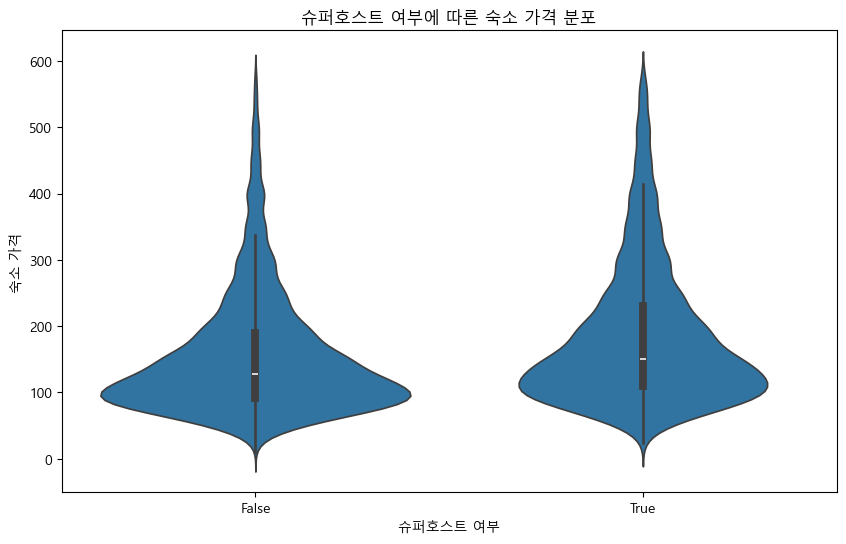

In [20]:
# 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x='슈퍼호스트1', y='숙소_가격', data=df)
plt.title('슈퍼호스트 여부에 따른 숙소 가격 분포')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('숙소 가격')
plt.show()


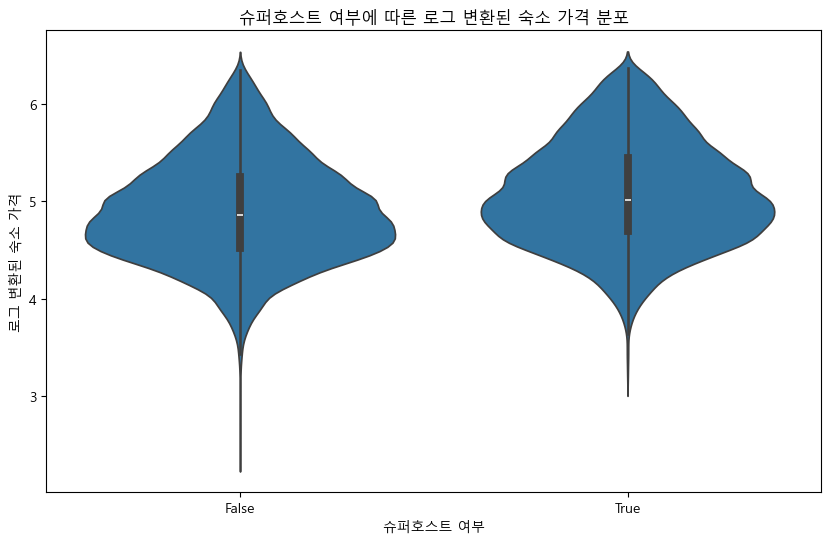

In [21]:
# 숙소 가격에 로그 변환 적용 (0 이상 가격에만 적용)
df['로그_숙소_가격'] = np.log1p(df['숙소_가격'])

# 로그 변환된 가격을 사용하여 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x='슈퍼호스트1', y='로그_숙소_가격', data=df)
plt.title('슈퍼호스트 여부에 따른 로그 변환된 숙소 가격 분포')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('로그 변환된 숙소 가격')
plt.show()


In [22]:
from scipy.stats import mannwhitneyu

# 슈퍼호스트와 비슈퍼호스트의 가격 데이터 추출
superhost_prices = df[df['슈퍼호스트1'] == True]['숙소_가격']
nonsuperhost_prices = df[df['슈퍼호스트1'] == False]['숙소_가격']

# Mann-Whitney U 테스트 수행
u_stat, p_value = mannwhitneyu(superhost_prices, nonsuperhost_prices, alternative='two-sided')

print("Mann-Whitney U 통계량:", u_stat)
print("P-값:", p_value)


Mann-Whitney U 통계량: 50589094.5
P-값: 1.9693864926285187e-104


In [23]:
# 슈퍼호스트 숙소의 가격 중앙값
superhost_median = df[df['슈퍼호스트1'] == True]['숙소_가격'].median()

# 비슈퍼호스트 숙소의 가격 중앙값
nonsuperhost_median = df[df['슈퍼호스트1'] == False]['숙소_가격'].median()

print("슈퍼호스트 숙소 가격 중앙값:", superhost_median)
print("비슈퍼호스트 숙소 가격 중앙값:", nonsuperhost_median)


슈퍼호스트 숙소 가격 중앙값: 150.0
비슈퍼호스트 숙소 가격 중앙값: 128.0


# 리뷰점수 숙소_지역, 숙소_유형
- 리뷰 점수와 숙소_지역과 관계가 있음
- 리뷰 점수와 숙소_유형과 관계 없음

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# OLS 모델 설정
# C() 함수는 범주형 변수임을 명시합니다.
model = ols('리뷰점수 ~ C(숙소_지역) + C(숙소_유형)', data=df).fit()

# ANOVA 테이블 생성
anova_results = sm.stats.anova_lm(model, typ=2)

# 결과 출력
print(anova_results)


              sum_sq       df          F        PR(>F)
C(숙소_지역)    9.700968     19.0  10.652290  1.805254e-32
C(숙소_유형)    0.195949      1.0   4.088126  4.319989e-02
Residual  885.145832  18467.0        NaN           NaN


In [25]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터셋 준비
data = df[['리뷰점수', '숙소_가격', '숙소_위치_리뷰점수', '숙소_청결도_리뷰점수']]

# 결측치 처리
data = data.dropna()

# 데이터 표준화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA 실행
pca = PCA(n_components=2)  # 주성분을 2개로 설정
principalComponents = pca.fit_transform(data_scaled)

# 주성분 DataFrame 생성
principalDf = pd.DataFrame(data=principalComponents, columns=['주성분 1', '주성분 2'])

# 설명된 분산 비율
print("설명된 분산 비율:", pca.explained_variance_ratio_)


설명된 분산 비율: [0.51999379 0.24171391]


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_scaled)  # data_scaled는 표준화된 데이터
print("주성분 (고유벡터):\n", pca.components_)  # 각 주성분의 방향을 나타내는 고유벡터
print("설명된 분산 (고유값):\n", pca.explained_variance_)  # 각 주성분의 고유값


주성분 (고유벡터):
 [[-0.62012271 -0.27230661 -0.43039987 -0.59670167]
 [-0.29056572  0.84593242  0.31854868 -0.31384174]]
설명된 분산 (고유값):
 [2.08008766 0.96690794]
